In [1]:
# numpy
import numpy as np
import pandas as pd
# for operate list
import operator
from functools import reduce
# for models
from keras.models import Sequential, Model
from keras.layers import * # Dense, Conv2D, Flatten, Dropout, LeakyRelu
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
# for plot images
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import scipy.io
import keras.preprocessing.image as img
# for progress bar
from tqdm.notebook import trange, tqdm
# for make zip archive
import shutil
# for mkdir
import pathlib
# for save image to file
from imageio import imsave

Using TensorFlow backend.


In [2]:
PATH_TRAIN_IMAGE = './images'
SHAPE_IMAGE = (64, 64, 3)
BATCH_SIZE = 32
latent_dim = 100
num_epoch = 15
num_batch = 20579 // BATCH_SIZE // 2
print(num_batch)

321


In [3]:
#Load data from .mat file
train_mat = scipy.io.loadmat("data/train_data.mat")

In [4]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    crops = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        ano_path = "Annotation/" + mat[train_or_test]['annotation_list'][0][0][i][0][0]
        tree = ET.parse(ano_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            crop = (xmin, ymin, xmin+w, ymin+w)
        crops.append(crop)
    df['path'] = paths
    df['crops'] = crops
    return df

In [5]:
#Unpack into pandas dataframe
train_df = unpack_mat(train_mat, 'train_info')
train_df.head()

,path,crops
0,images/n02085620-Chihuahua/n02085620_5927.jpg,"(30, 14, 236, 220)"
1,images/n02085620-Chihuahua/n02085620_4441.jpg,"(107, 110, 296, 299)"
2,images/n02085620-Chihuahua/n02085620_1502.jpg,"(51, 13, 369, 331)"
3,images/n02085620-Chihuahua/n02085620_1916.jpg,"(8, 7, 398, 397)"
4,images/n02085620-Chihuahua/n02085620_13151.jpg,"(176, 29, 379, 232)"


In [6]:
#Data cleaning
#Find any image with improper size
for index, row in train_df.iterrows():
    s = img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))).shape
    if(s != (64,64,3)):
        print("Bad index",index)
        print("Size", s)
        print("Path", row['path'])

Bad index 7904
Size (64, 64, 4)
Path images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


In [7]:
#Remove bad dog from the dataset
train_df = train_df[train_df['path'] != 'images/n02105855-Shetland_sheepdog/n02105855_2933.jpg']
#Convert images in the dataset into array of pixel values
X_train = np.array([img.img_to_array(Image.open(row['path'])) for index, row in train_df.iterrows()])

In [8]:
#EDA 
heights = [x.shape[0] for x in X_train]
widths = [x.shape[1] for x in X_train]
avgHeight = np.mean(heights)
avgWidth = np.mean(widths)

Average image height is: 386.0


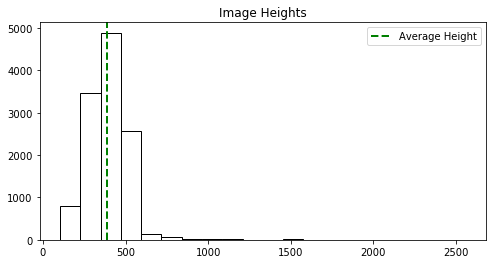

In [9]:
# Plot Histogram of image heights
print("Average image height is:", round(avgHeight))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.hist(heights, bins=20, range=(np.min(heights), np.max(heights)), color='white',  edgecolor='black')
ax.set_title("Image Heights")
ax.axvline(x = avgHeight, linewidth=2, color='g', ls = "--", label = "Average Height")
ax.legend()

Average image width is: 443.0


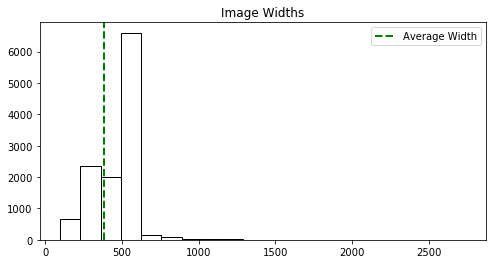

In [10]:
# Plot Histogram of image widths
print("Average image width is:", round(avgWidth))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.hist(widths, bins=20, range=(np.min(widths), np.max(widths)), color='white',  edgecolor='black')
ax.set_title("Image Widths")
ax.axvline(x = avgHeight, linewidth=2, color='g', ls = "--", label = "Average Width")
ax.legend()

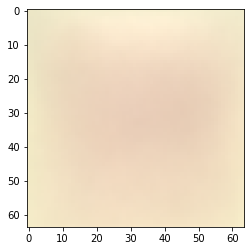

In [11]:
X_train = np.array([img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))) for index, row in train_df.iterrows()])
aggregate_image = np.mean(X_train, axis=0)
plt.imshow(img.array_to_img(aggregate_image))

In [12]:
def normalize_image(X):
    return (X-127.5)/127.5

In [13]:
X_train = normalize_image(X_train)

In [14]:
# datagen = ImageDataGenerator(
#     horizontal_flip = True,
#     rotation_range = 20,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     preprocessing_function = lambda X: (X-127.5)/127.5
# )
# data_loader=datagen.flow_from_directory(
#     PATH_TRAIN_IMAGE,
#     target_size = SHAPE_IMAGE[:-1], 
#     class_mode = None,
#     batch_size = BATCH_SIZE)

In [15]:
# returns numbers between .7 and 1.2
# this will then be multipled by the label 1.0 to smooth it over
def label_smooth_factor(size):
    return np.random.rand(size)/2 + .7

In [16]:
# Switches Some images to the oposite group
def swap_group(prob_flip,size,real_images_batch,fake_images_batch):
    for i in range(size):
        flip = np.random.rand()
        if(flip<prob_flip):
            holder = real_images_batch[i]
            real_images_batch[i] = fake_images_batch[i]
            fake_images_batch[i] = holder
    return real_images_batch, fake_images_batch

In [17]:
def generate_real_samples(n_samples=BATCH_SIZE):
    return X_train[np.random.randint(0, X_train.shape[0],n_samples)], np.reshape(np.ones(n_samples)*label_smooth_factor(n_samples),(n_samples,1))

In [18]:
def show_images(ary, rows, cols):
    plt.figure(figsize=(cols*3, rows*3))
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, row*cols+col+1)
            img = (ary[row*cols+col, :] + 1) / 2
#             img = ary[row*cols+col]
            plt.axis('off')
            plt.title(f'{row*cols+col}')
            plt.imshow(img)
    plt.show()

shape of data: (32, 64, 64, 3)
min, max of data: -1.0 1.0
shape of y (32, 1)
min, max of y 0.7248908681009258 1.1968229230474536
head 5 of y [[1.03271439]
 [1.08207835]
 [0.73801716]
 [1.07256781]
 [1.02705099]]


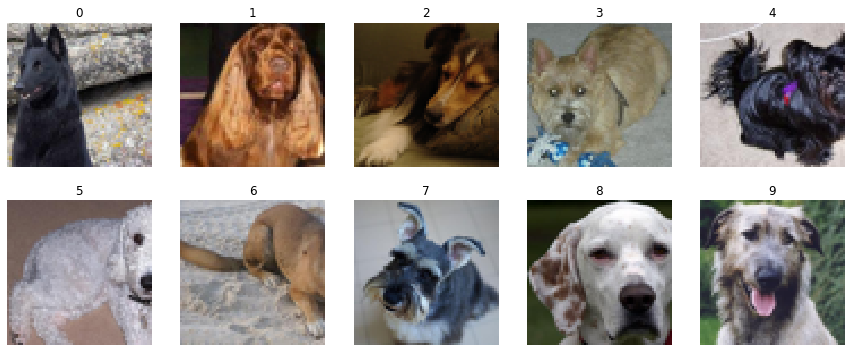

In [19]:
data, y = generate_real_samples()
print('shape of data:', data.shape) # => (32, 64, 64, 3)
print('min, max of data:', data.min(), data.max()) # => 0.0 1.0
print('shape of y', y.shape) # => (32, 1)
print('min, max of y', y.min(), y.max()) # => 1.0 1.0
print('head 5 of y', y[:5]) # => [[1.] [1.] ...]

show_images(data,2, 5)

In [20]:
def define_discriminator():
    model = Sequential([
        InputLayer(input_shape=SHAPE_IMAGE),
        
        Conv2D(32, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(256, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(512, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
# compile discriminator
discriminator = define_discriminator()
discriminator_opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_opt)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)        

In [22]:
def define_generator():
    model = Sequential([
        Dense((64*8*8), input_shape=(latent_dim,)),
        Reshape((8,8,64)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 16x16
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 32x32
        UpSampling2D(),
        Conv2D(32, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 64x64
        UpSampling2D(),
        Conv2D(16, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2D(3, kernel_size=3, padding='same'),
        Activation('tanh'),
    ])
    
    return model

In [23]:
# make generator
generator = define_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)       

In [24]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    noize = np.random.normal(0.0, 1.0, (n_samples, latent_dim))
    # noize = np.random.uniform(-1, 1, (n_samples, latent_dim))
    return noize

In [25]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

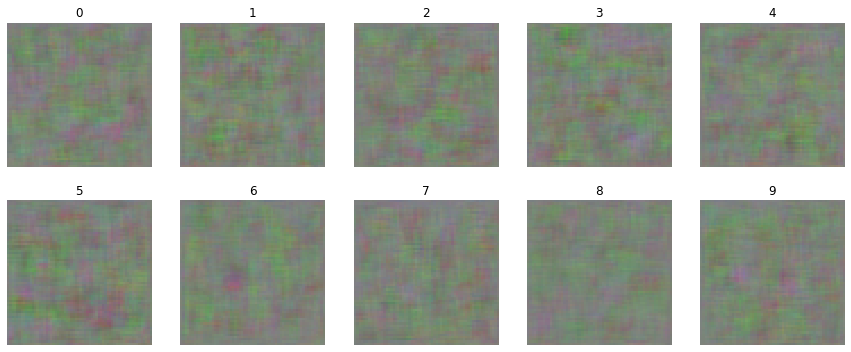

In [26]:
# generator output test
X, y = generate_fake_samples(generator, latent_dim, 10)
show_images(X, 2, 5)

In [27]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    d_model_fixed = Model(inputs=d_model.inputs, outputs=d_model.outputs)
    d_model_fixed.trainable = False
    # connect them
    model = Sequential([
        InputLayer(input_shape=(latent_dim,)),
        g_model,
        d_model_fixed
    ])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [28]:
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         474851    
_________________________________________________________________
model_1 (Model)              (None, 1)                 1574593   
Total params: 2,049,444
Trainable params: 474,499
Non-trainable params: 1,574,945
_________________________________________________________________


In [29]:
def train_discriminator():
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(BATCH_SIZE//2)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, BATCH_SIZE//2)
    
    image_batch, generated_images = swap_group(.025,BATCH_SIZE//2,X_real,X_fake)
    
    loss_real = discriminator.train_on_batch(X_real, y_real)
    loss_fake = discriminator.train_on_batch(X_fake, y_fake)
    
    return (loss_real+loss_fake)*0.5

In [30]:
def train_gan(num_loop=1):
    # prepare points in latent space as input for the generator
    X = generate_latent_points(latent_dim, BATCH_SIZE)
    # create inverted labels for the fake samples
    y = np.reshape(np.ones(BATCH_SIZE)*label_smooth_factor(BATCH_SIZE),(BATCH_SIZE,1))
    for i in range(num_loop):
        loss = gan.train_on_batch(X, y)
    return loss

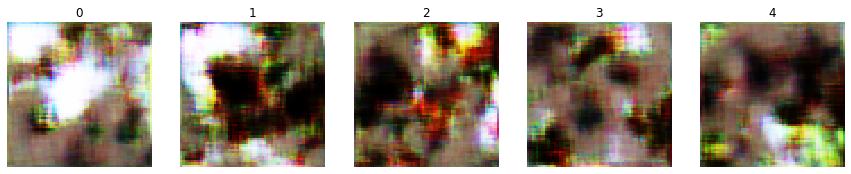

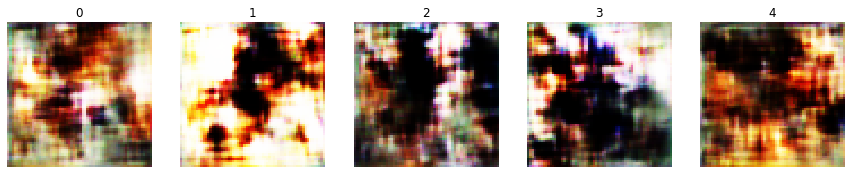

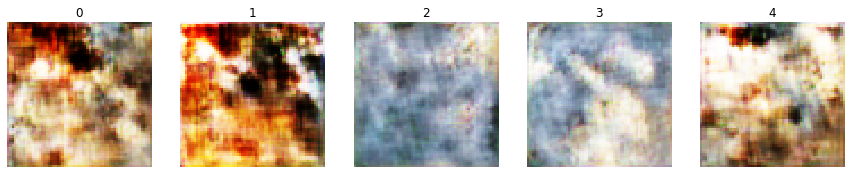

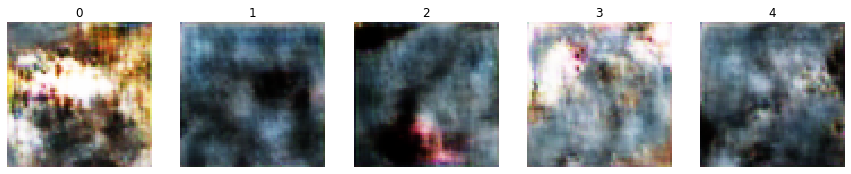

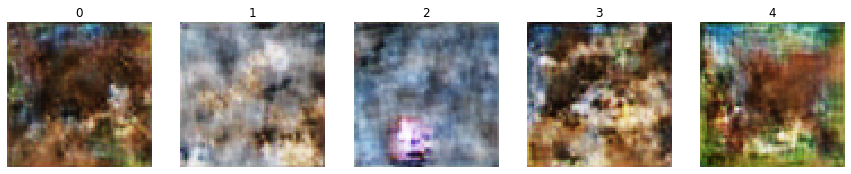

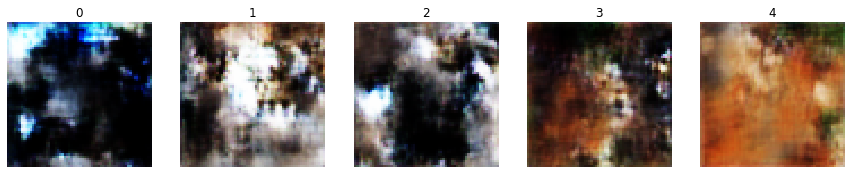

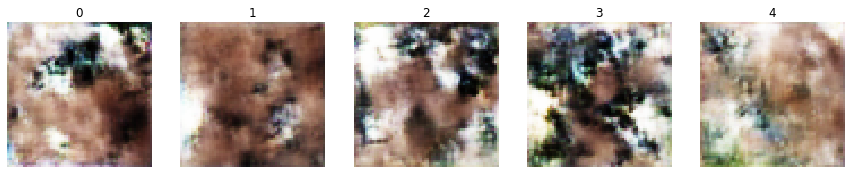

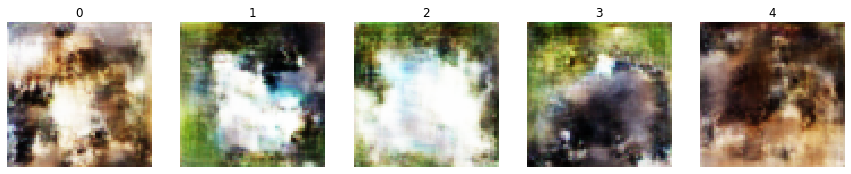

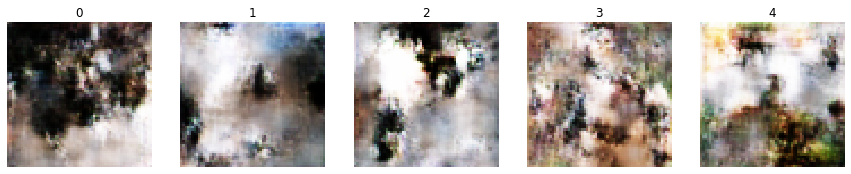

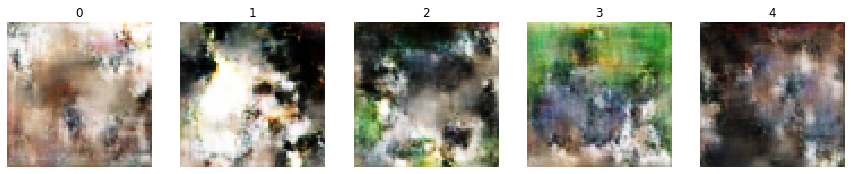

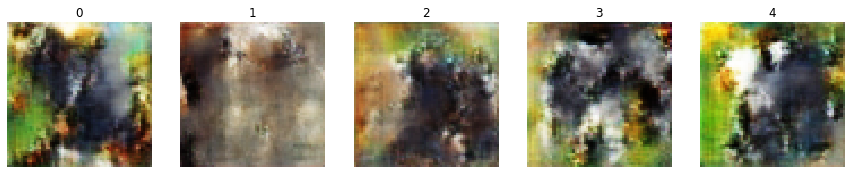

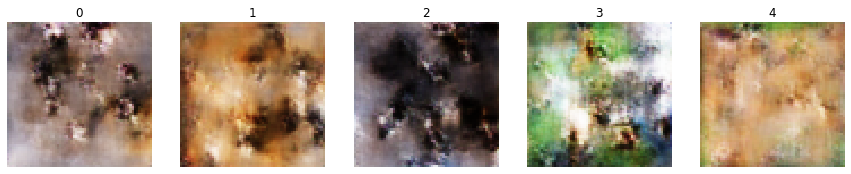

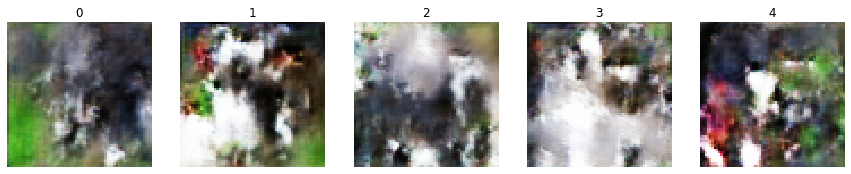

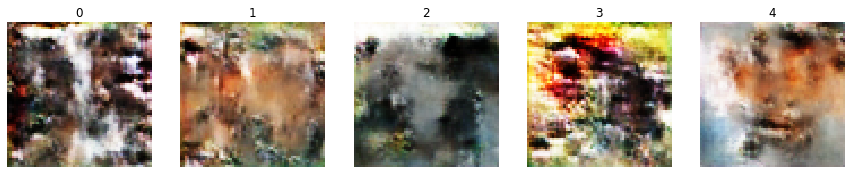

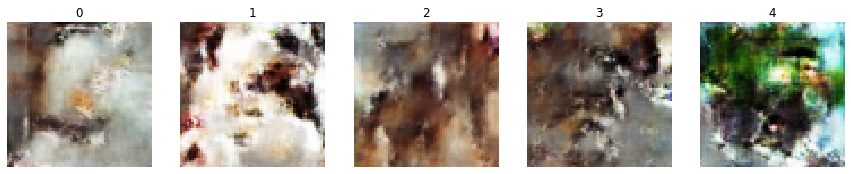

In [32]:
# train all
history = np.zeros((num_epoch, num_batch, 2))
dogs_at_epoch = np.zeros((num_epoch, *SHAPE_IMAGE))

for i in tqdm(range(num_epoch), desc='epoch'):
    # data_loader.reset()
    pbar_batch = tqdm(range(num_batch), desc='batch')
    
    for j in pbar_batch:
        d_loss = train_discriminator()
        g_loss = train_gan()
        pbar_batch.set_description(f'{i:>2}, d_loss:{d_loss:.2}, g_loss:{g_loss:.2}')
        history[i, j, :] = d_loss, g_loss
        
    generated_imgs = generate_fake_samples(generator, latent_dim, 5)[0]
    show_images(generated_imgs, 1, 5)
    dogs_at_epoch[i, :] = generated_imgs[0,:]

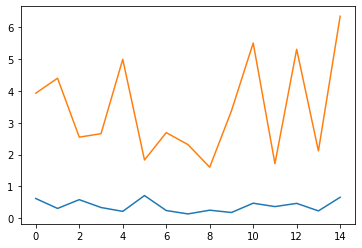

In [33]:
# show_images(dogs_at_epoch[:, :, :, :], num_epoch//5, 5)
plt.plot(history[:,-1,:])

In [34]:
# generate images
latent_points = generate_latent_points(latent_dim, 10000)
# generate images
X = generator.predict(latent_points)

print(X.shape, X[0].min(), X[0].max())

(10000, 64, 64, 3) -0.95080924 0.88701683


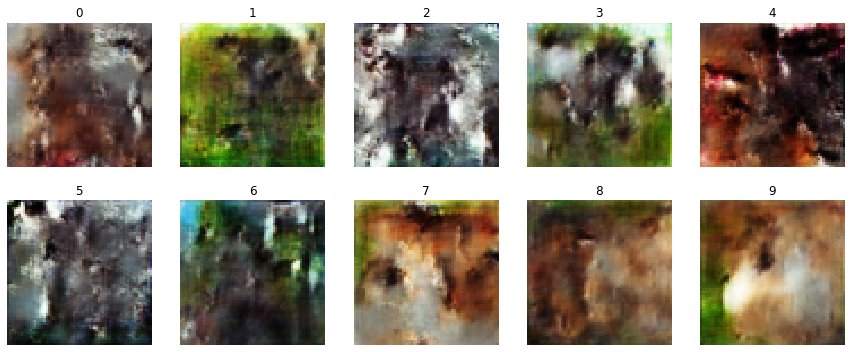

In [35]:
show_images(X, 2, 5)

In [36]:
history[4,-1:,:]

array([[0.21693902, 4.98818588]])

In [37]:
history[14,-1:,:]

array([[0.65969348, 6.34117317]])

In [38]:
history[13,-1:,:]

array([[0.23225754, 2.11411405]])